In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime

In [227]:
get_series = lambda x, y: np.append(np.append(x[:,0], x[-1, 1:]), y[-1])

In [363]:
def get_plot(X, Y, w, b, point_freq = 1, figsize=(20,5), **kwargs):
    fig, ax = plt.subplots(figsize=figsize)
    X_ser = get_series(X, Y)
    ax.scatter(list(range(len(X_ser)))[::point_freq], X_ser[::point_freq])
    ax.plot(range(X.shape[0]), (X.dot(w)+b).ravel(),'red')
    ax.set_title(f'Model with w: {w.round(6).ravel()} b: {b.round(6)} {kwargs}')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    plt.show()

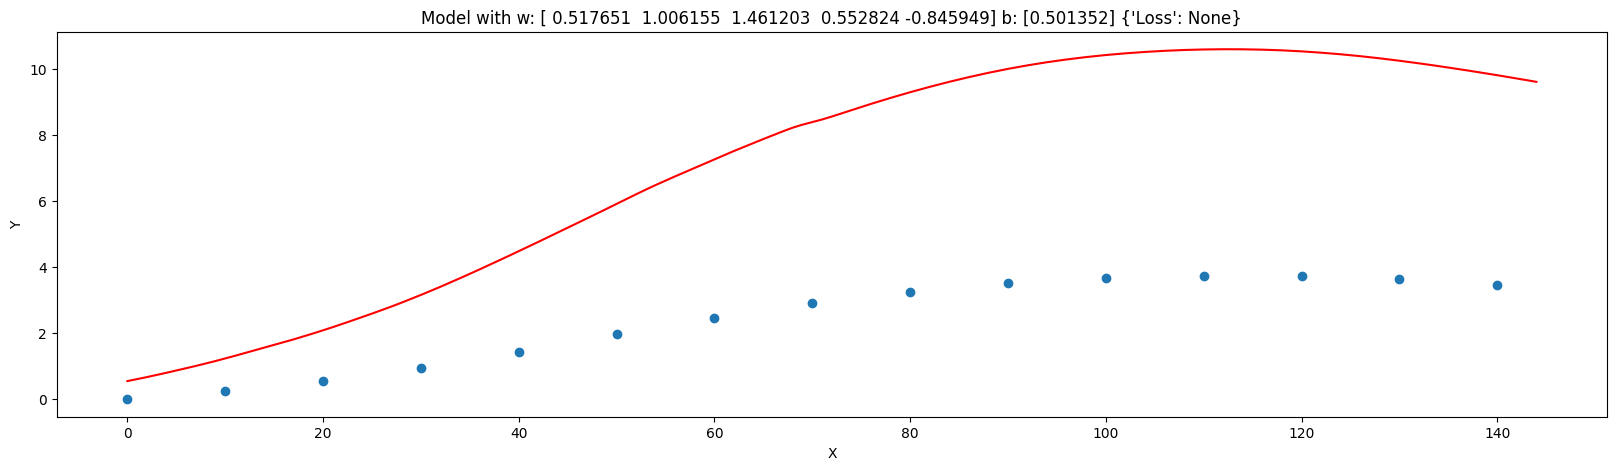

In [365]:
# Plotting for some random w and b
get_plot(X, Y, w=np.random.randn(5, 1), b=np.random.randn(1), point_freq=10, Loss = None)

## Data

Can be pulled from Here [https://www.macrotrends.net/global-metrics/countries/IND/india/population]

In [261]:
LOOK_BACK = 5

In [262]:
df = pd.read_csv('india-population-2024-09-06.csv', skiprows = 13)
df = df.rename(columns=lambda x: x.strip())

reference = df['Population'][0]

df['Population'] = df['Population']/df['Population'][0] - 1
df['Year'] = pd.DatetimeIndex(df['date']).year
df = df[['Year', 'Population']]
df.head()

,Year,Population
0,1950,0.000000
1,1951,0.022131
2,1952,0.044748
3,1953,0.067802
4,1954,0.091620


In [263]:
for i in range(LOOK_BACK):
    df[f'X_{i+1}'] = df['Population'].shift(-i)
df['Y'] = df['Population'].shift(-LOOK_BACK)
# Dropping a record to keep number number divisible by 10
df = df.drop(df.index[-6:])

df.head()

,Year,Population,X_1,X_2,X_3,X_4,X_5,Y
0,1950,0.000000,0.000000,0.022131,0.044748,0.067802,0.091620,0.116399
1,1951,0.022131,0.022131,0.044748,0.067802,0.091620,0.116399,0.141828
2,1952,0.044748,0.044748,0.067802,0.091620,0.116399,0.141828,0.167817
3,1953,0.067802,0.067802,0.091620,0.116399,0.141828,0.167817,0.194035
4,1954,0.091620,0.091620,0.116399,0.141828,0.167817,0.194035,0.220937


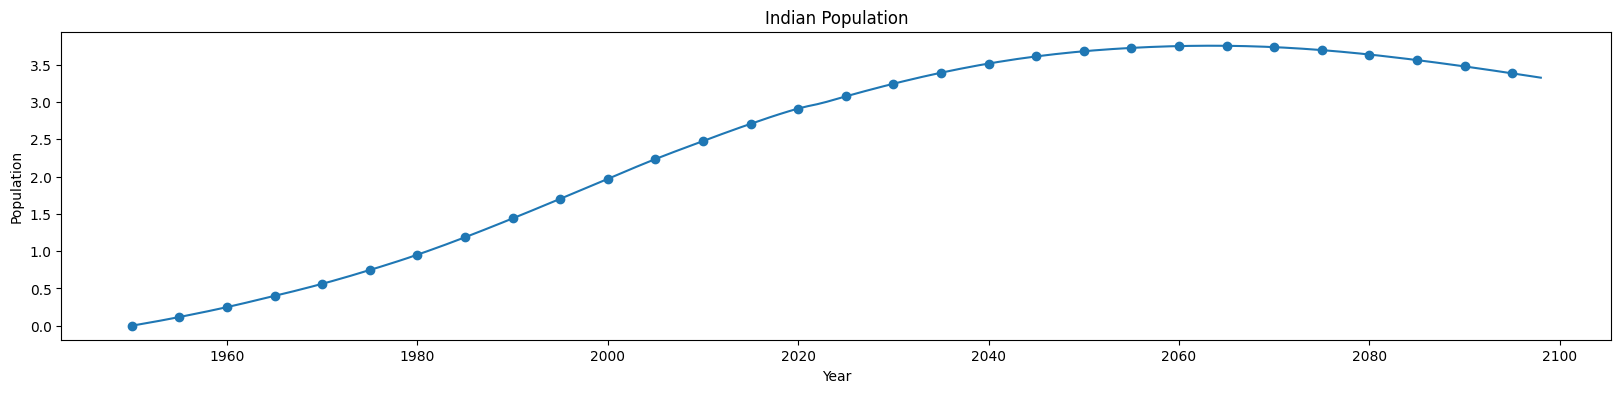

In [119]:
# Visualizing Series

fig, ax = plt.subplots(1, 1, figsize=(20, 4))
ax.plot(df['Year'], df['Population'])
ax.scatter(df['Year'][::5], df['Population'][::5])
ax.set_xlabel('Year')
ax.set_ylabel('Population')
ax.set_title('Indian Population')
plt.show()

## Stochastic Gradient Descent

In [360]:
X = df[['X_1', 'X_2', 'X_3', 'X_4', 'X_5']].values
Y = df[['Y']].values

TRAIN_SIZE = 120

X_train, Y_train = X[:TRAIN_SIZE], Y[:TRAIN_SIZE]
X_test, Y_test = X[TRAIN_SIZE:], Y[TRAIN_SIZE:]

# Testing Shape
X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((120, 5), (120, 1), (25, 5), (25, 1))

In [367]:
class WMA_SGD:
    def __init__(self, lr=0.01, epochs=2, batch_size=5, lookback=5):
        # Hyper Parameters
        self.lr = lr
        self.epochs = epochs
        self.batch_size = batch_size
        self.lookback = lookback
        # Parameters
        self.w = np.random.randn(lookback,1)
        self.b = np.random.randn()
        # Callback Variables
        self.param_history = []
        self.loss_history = []

    def forward(self, x):
        return x.dot(self.w) + self.b

    def loss(self, y, y_pred):
        return 0.5*np.mean((y_pred - y)**2)

    def train(self, X, Y):
        # # Make data lenght multiple of batch size [Drop Extra records]
        # X = X[:-(X.shape[0]%self.batch_size)]
        # Y = y[:-(y.shape[0]%self.batch_size)]
        # Make Batches
        X = X.reshape((-1, self.batch_size, self.lookback))
        Y = Y.reshape((-1, self.batch_size, 1))

        # Run Epoch
        for i in range(self.epochs):
            local_loss = []
            for (x, y) in zip(X, Y):
                y_pred = self.forward(x)
                loss = self.loss(y, y_pred)
                # Gradient Update
                self.w = self.w - self.lr * np.mean((y_pred - y) * x, axis=0).reshape(self.lookback, 1)
                self.b = self.b - self.lr * np.mean(y_pred - y)
                # Save History
                self.loss_history.append(loss)
                self.param_history.append((self.w, self.b))

            # Break Training if weights are not updating
            if np.sum((self.param_history[-1][0] - self.param_history[-2][0])**2) < 0.01:
                break

In [373]:
obj = WMA_SGD(lr = 0.01, epochs = 3, batch_size = 10)
obj.train(X_train, Y_train)

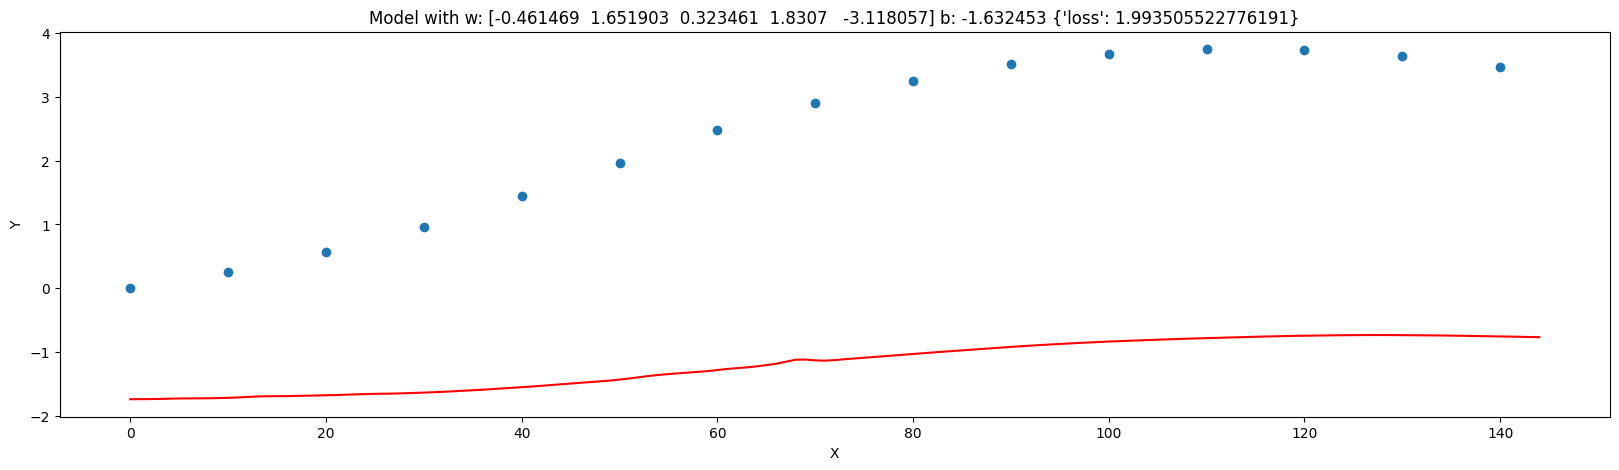

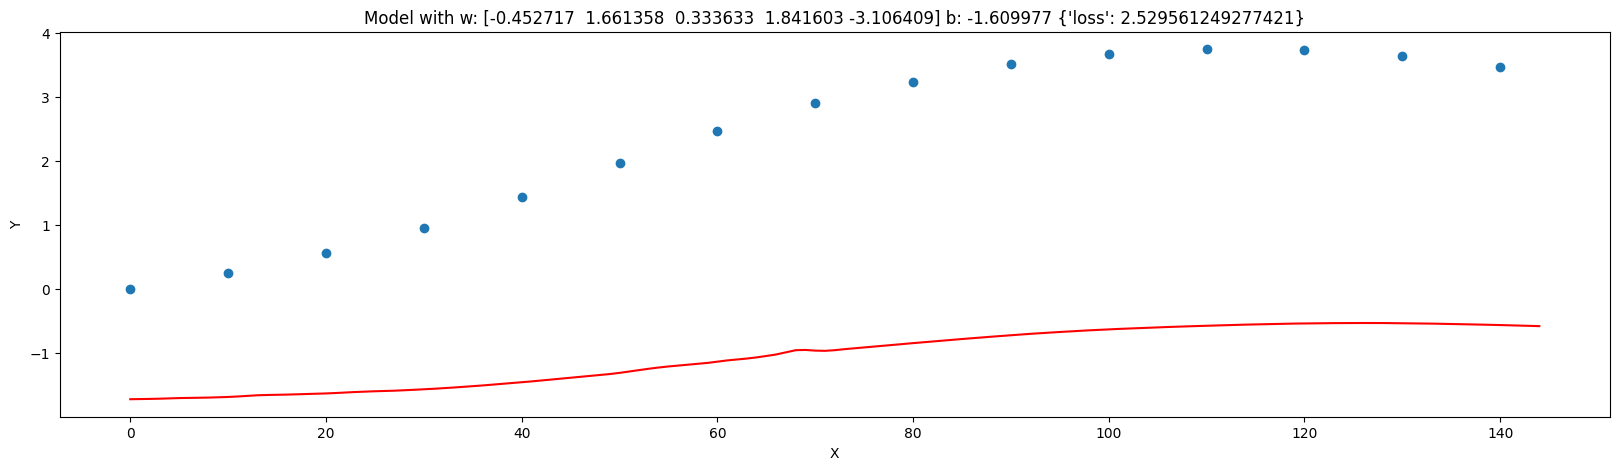

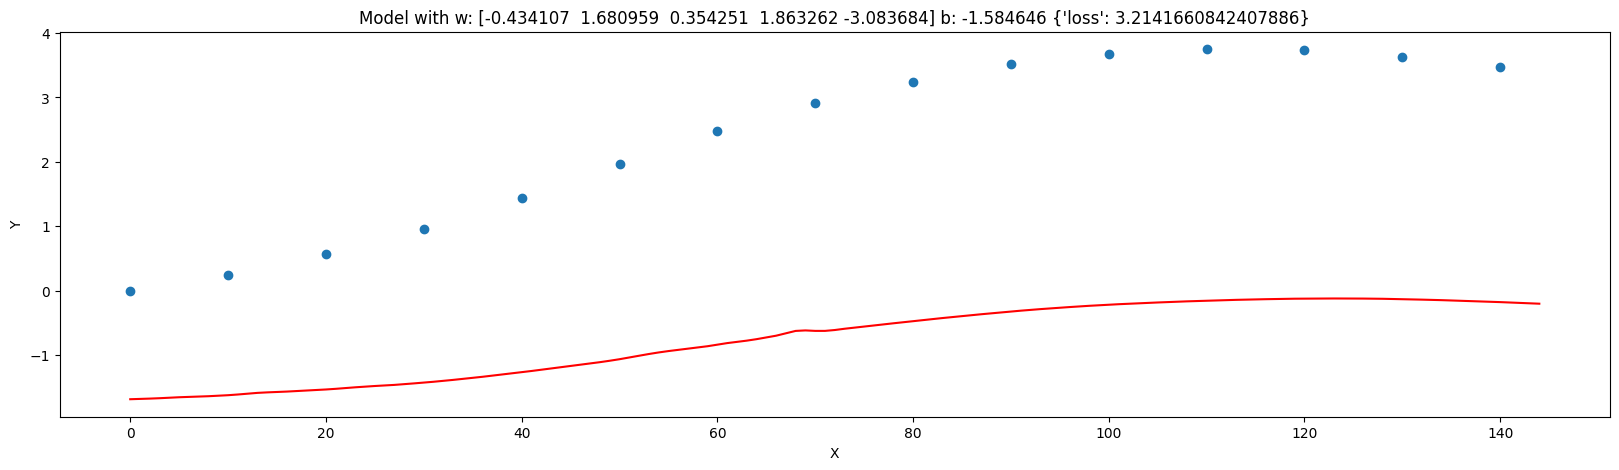

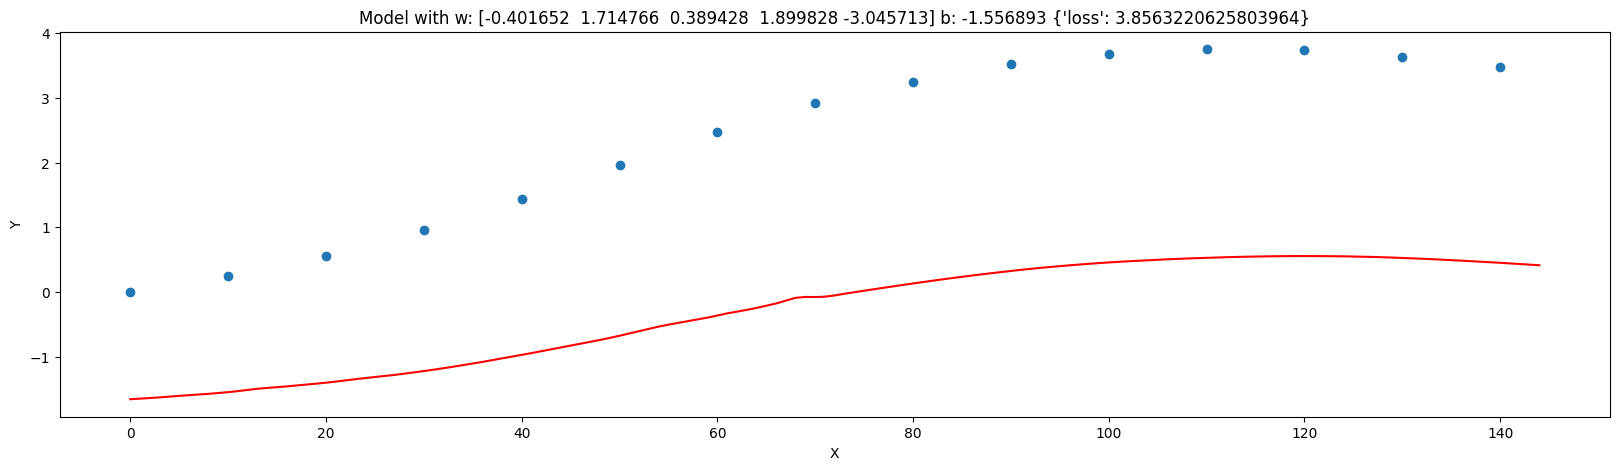

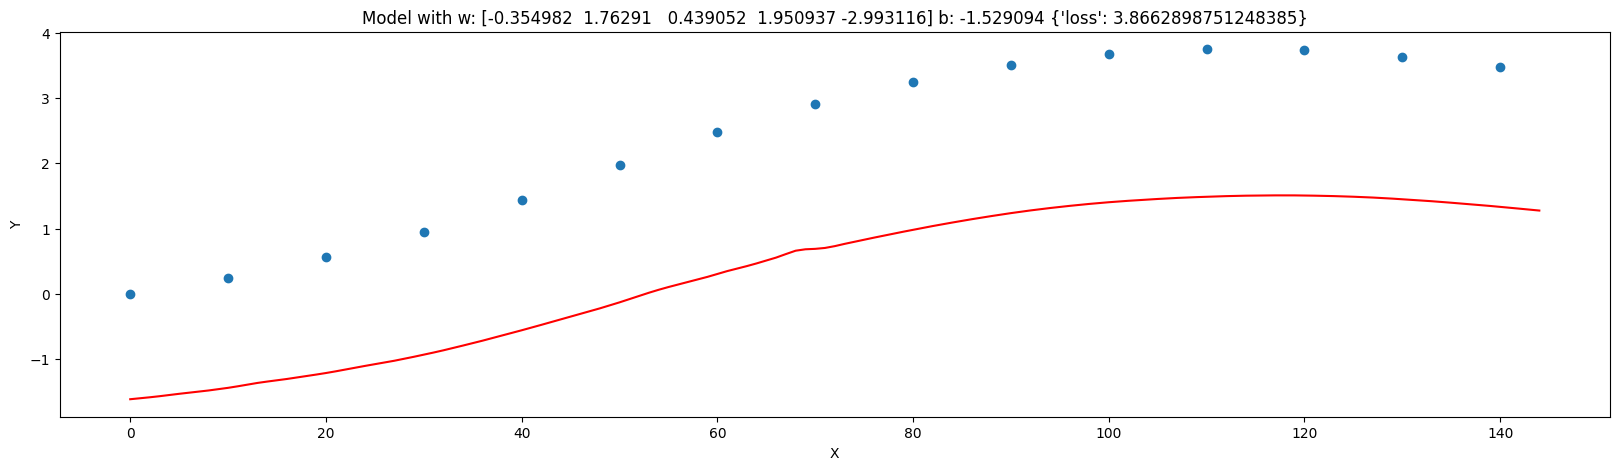

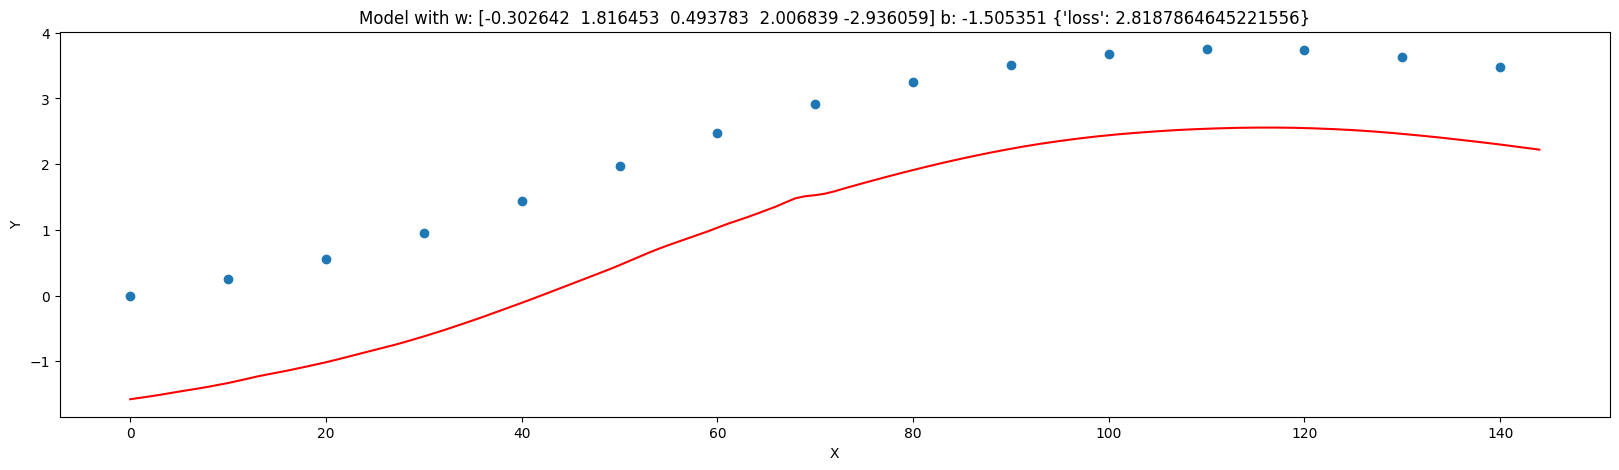

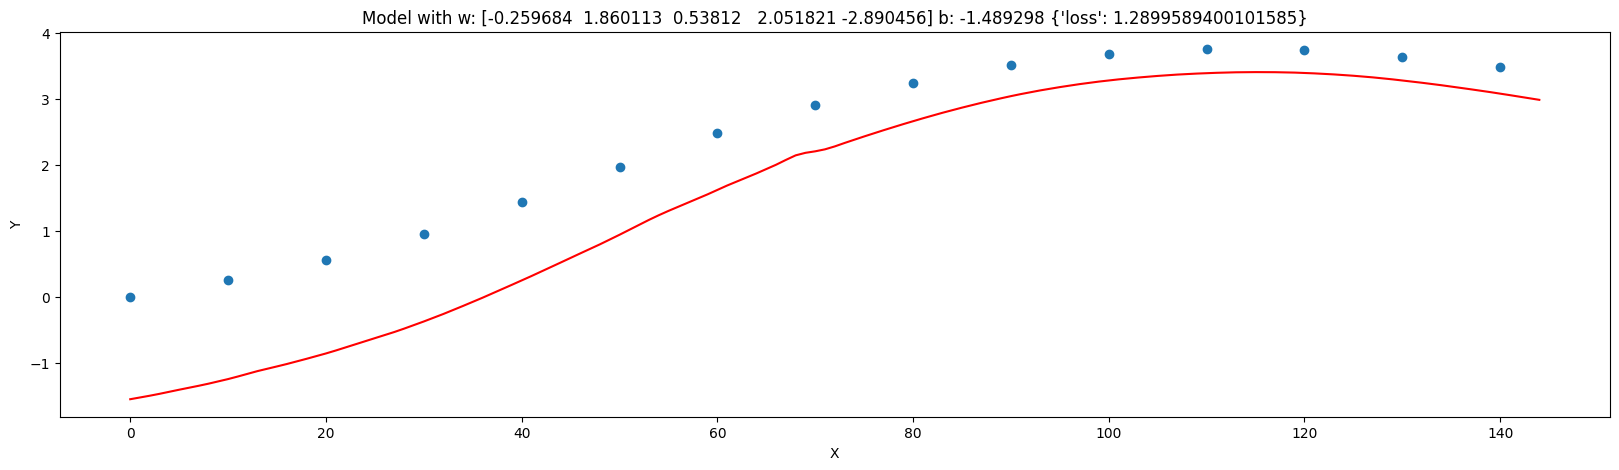

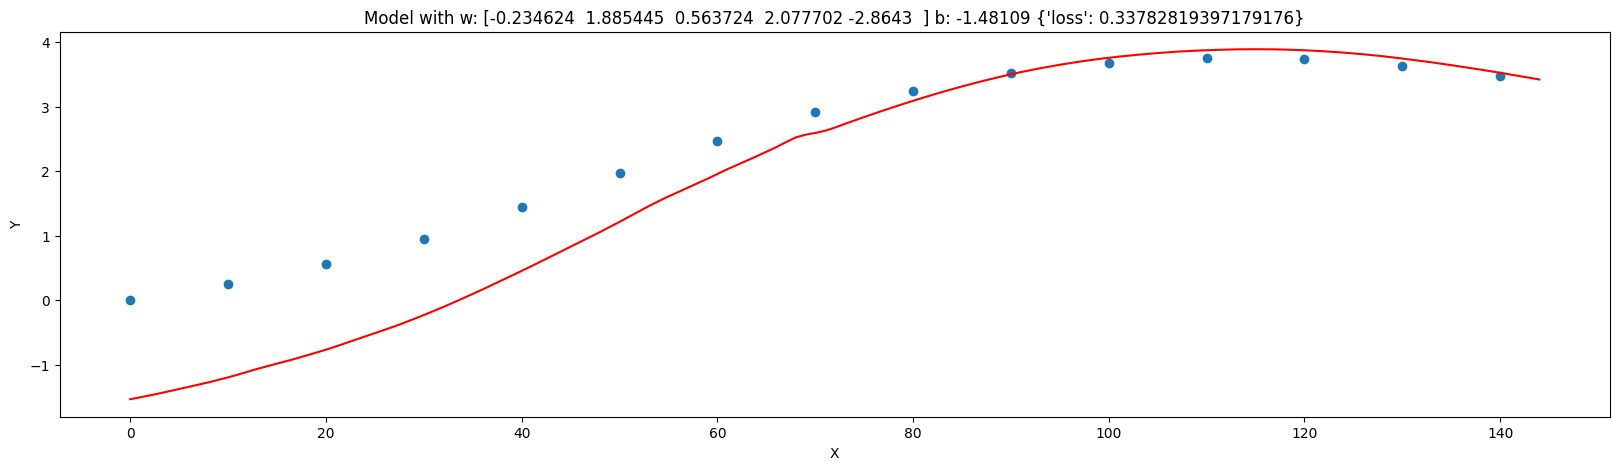

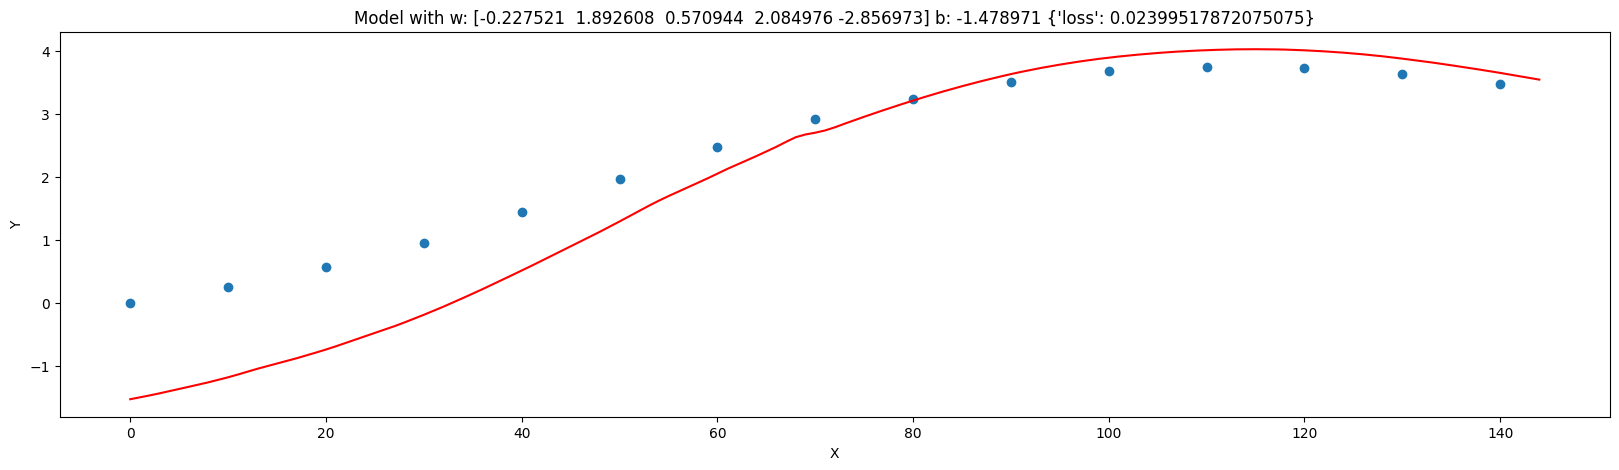

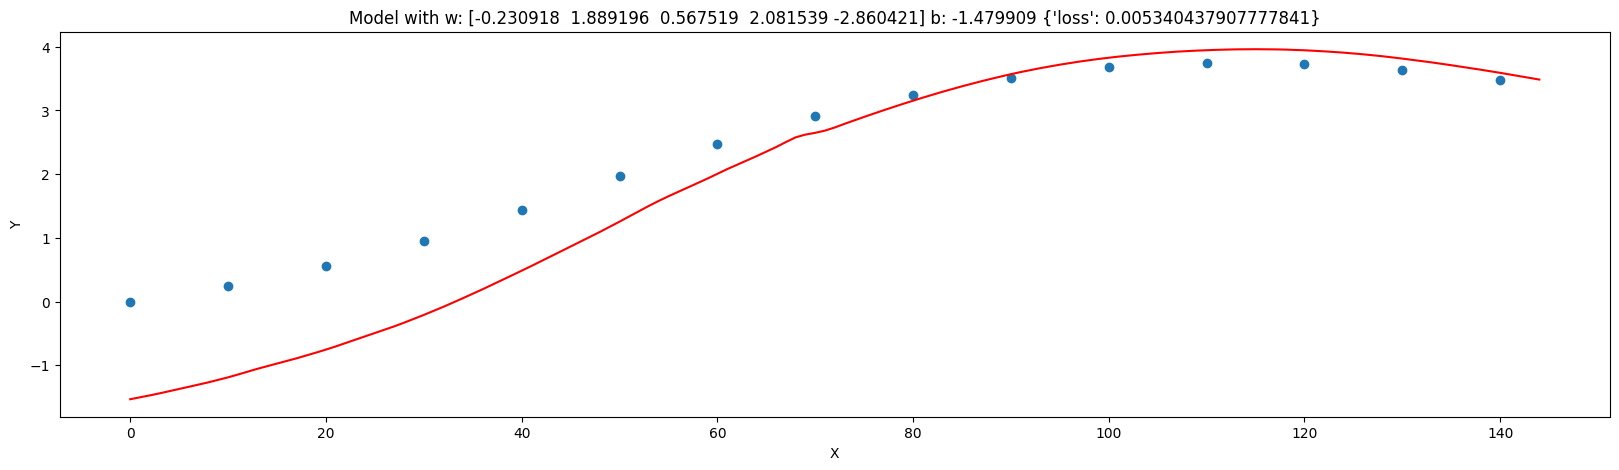

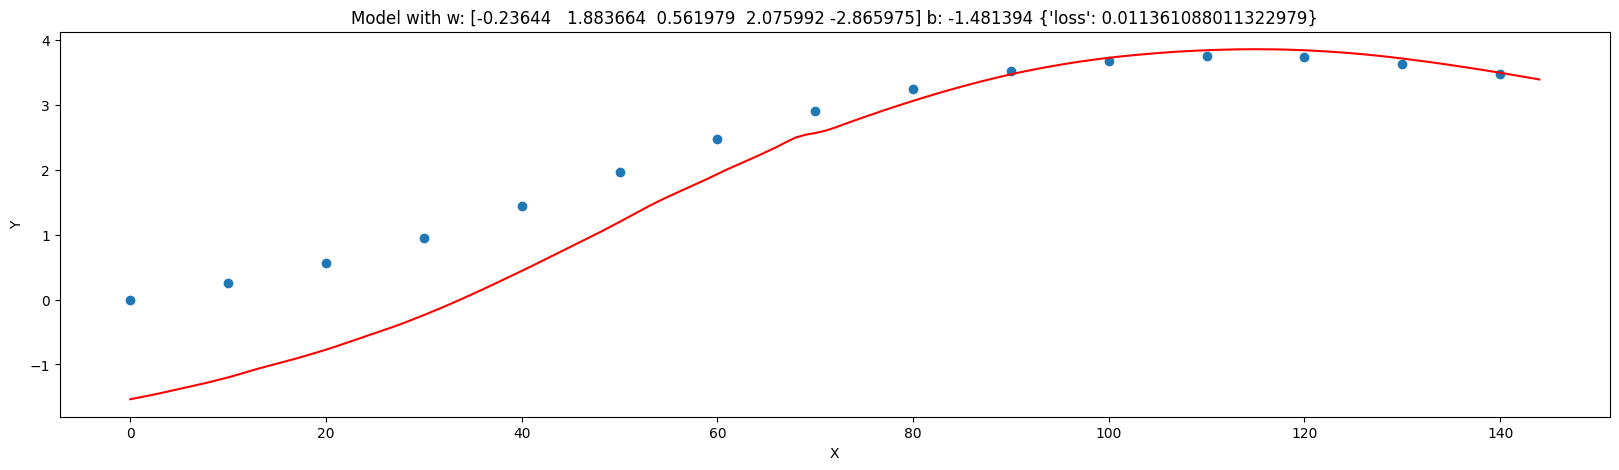

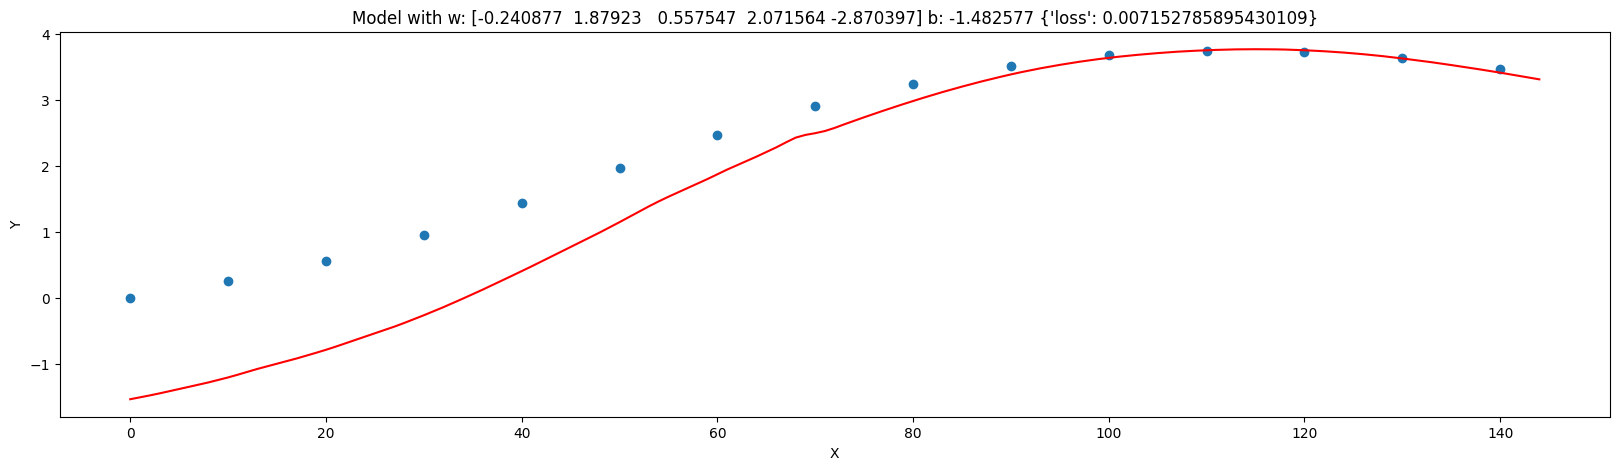

In [374]:
for ((w,b), loss) in zip(obj.param_history, obj.loss_history):
    get_plot(X, Y, w, b, point_freq=10, loss=loss)

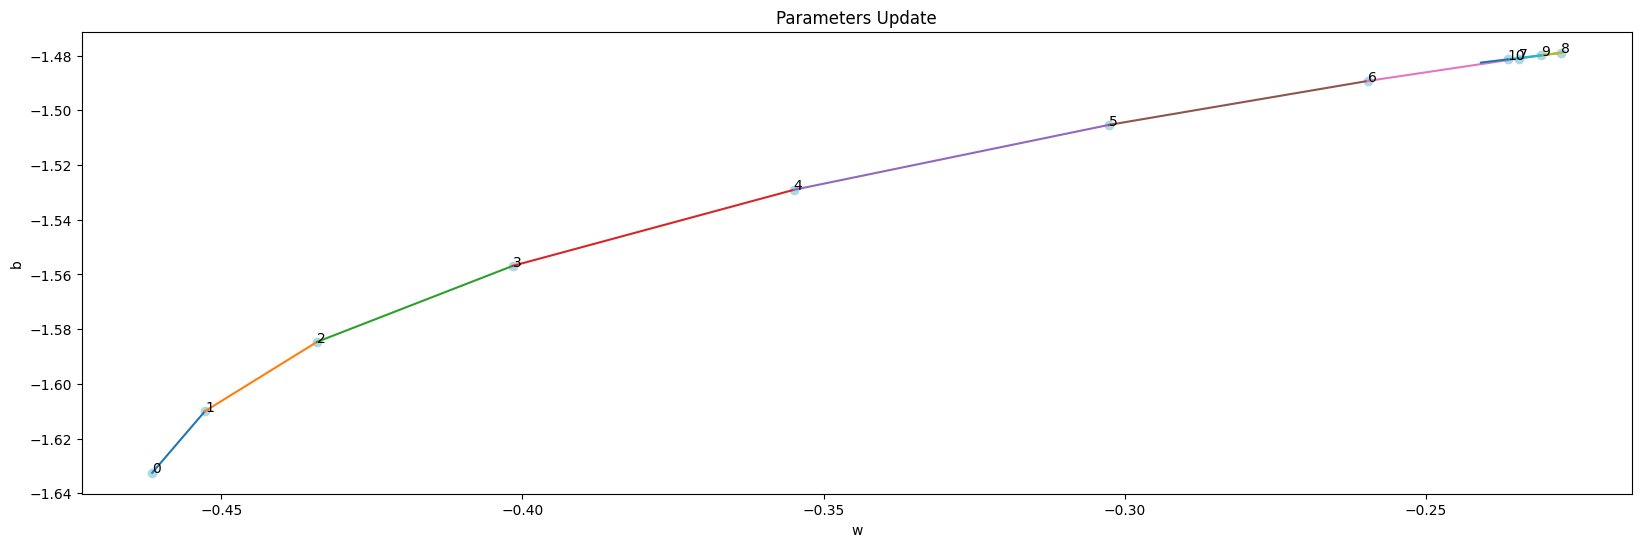

In [375]:
# Jumps in Parameter Space

# Has to be in range [0, 5)
index = 0

plt.figure(figsize=(20, 6))

for idx, i in enumerate(range(0, len(obj.param_history)-1, 1)):
    w, b = obj.param_history[i]
    w_next, b_next = obj.param_history[i+1]
    plt.plot([w[index], w_next[index]], [b, b_next])
    plt.scatter(w[index], b, color='lightblue')
    plt.annotate(idx, (w[index], b))
plt.xlabel('w')
plt.ylabel('b')
plt.title('Parameters Update')
plt.show()

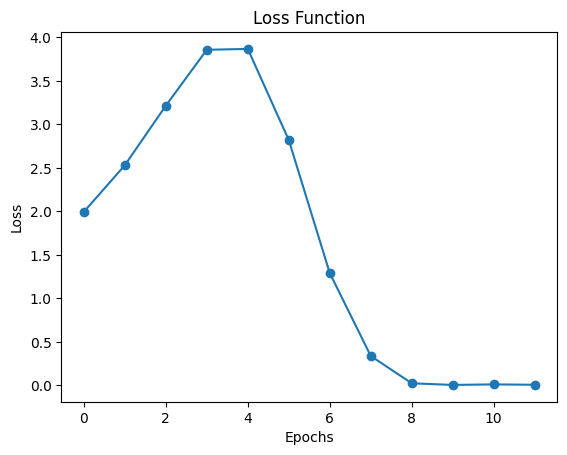

In [376]:
# Loss function

plt.scatter(range(len(obj.loss_history)), obj.loss_history)
plt.plot(range(len(obj.loss_history)), obj.loss_history)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Function")
plt.show()